In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle 
import torch
import numpy as np

In [3]:
import matplotlib.pyplot as plt
import json
import re

In [4]:
import argparse
import os
import sys
sys.path.append('/u/dbeaglehole/mech_interp/neural_controllers/')

from neural_controllers import NeuralController
from utils import load_model

## Llama 3.8b

In [5]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os

# Define the range of seeds and methods
seeds = np.arange(20)
methods = ['pca', 'rfm', 'linear', 'logistic']
# methods = ['linear', 'logistic', 'rfm']
# Initialize dictionaries to store validation and test results
d_val = {method: {} for method in methods}
d_test = {method: {} for method in methods}
trivial_metrics_val = []
trivial_metrics_test = []
selected_test_metrics = {method: [] for method in methods}

# Load data for each method
for method in methods:
    # Initialize lists to store results for each seed
    for s in seeds:
        # Paths for validation and test metrics
        path_val = f'../fava_annotated_results/llama_3_8b_it_{method}_seed_{s}_val_metrics.pkl'
        path_test = f'../fava_annotated_results/llama_3_8b_it_{method}_seed_{s}_test_metrics.pkl'
        
        # print(path_val, path_test)
        # Check if files exist
        if not os.path.exists(path_val):
            print(f"Validation file not found: {path_val}")
            continue
        if not os.path.exists(path_test):
            print(f"Test file not found: {path_test}")
            continue
            
        # Load validation and test results
        with open(path_val, 'rb') as f:
            val_results = pickle.load(f)
        with open(path_test, 'rb') as f:
            test_results = pickle.load(f)
        
        # Get layer keys (excluding any non-layer keys)
        layers_val = [k for k in val_results.keys() if isinstance(val_results[k], dict)]
        layers_test = [k for k in test_results.keys() if isinstance(test_results[k], dict)]
        
        
        # Collect per-layer metrics for validation
        for key in layers_val:
            if key not in d_val[method]:
                d_val[method][key] = []
            d_val[method][key].append(val_results[key])
        
        # Collect per-layer metrics for test
        for key in layers_test:
            if key not in d_test[method]:
                d_test[method][key] = []
            d_test[method][key].append(test_results[key])
        
        # Identify the layer with the highest validation accuracy
        if layers_val:  # Check if there are any layers
            best_layer = max(layers_val, key=lambda x: val_results[x]['acc'])
            best_test_metrics = test_results.get(best_layer, {})
            
            # Store all metrics for the selected test layer
            selected_test_metrics[method].append(best_test_metrics)

# Compute average and standard deviation of selected test metrics
average_selected_test_metrics = {}
std_selected_test_metrics = {}
for method in methods:
    test_metrics_list = selected_test_metrics[method]
    if test_metrics_list:
        # Initialize dict for each metric
        metrics_dict = {}
        for metric in test_metrics_list[0].keys():  # Assuming all dicts have same metrics
            values = [metrics[metric] for metrics in test_metrics_list]
            metrics_dict[metric] = {
                'mean': np.mean(values),
                'std': np.std(values)
            }
        average_selected_test_metrics[method] = metrics_dict
    else:
        average_selected_test_metrics[method] = {}

# Print all metrics for each method
print("\nTest Metrics (Selected by Best Validation Layer):")
for method in methods:
    print(f"\n{method.upper()}:")
    metrics_dict = average_selected_test_metrics[method]
    for metric, values in metrics_dict.items():
        print(f"{metric}: {values['mean']:.4f} ± {values['std']:.4f}")


Test Metrics (Selected by Best Validation Layer):

PCA:
acc: 58.2000 ± 4.8539
precision: 0.5998 ± 0.1082
recall: 0.3534 ± 0.1357
f1: 0.4271 ± 0.0582

RFM:
acc: 69.9500 ± 3.8402
precision: 0.6745 ± 0.0656
recall: 0.6682 ± 0.0648
f1: 0.6684 ± 0.0485

LINEAR:
acc: 62.0500 ± 3.9934
precision: 0.5805 ± 0.0623
recall: 0.6355 ± 0.0994
f1: 0.6010 ± 0.0558

LOGISTIC:
acc: 61.4000 ± 3.3526
precision: 0.7079 ± 0.0977
recall: 0.2755 ± 0.0478
f1: 0.3925 ± 0.0516


In [6]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os

# Define the range of methods
methods = ['linear', 'rfm', 'logistic', 'rfm_linear', 'linear_rfm']
# methods = ['rfm', 'linear']

# Initialize dictionaries to store results
d = {method: {} for method in methods}
trivial_accs = []

# Initialize dictionary to store agg results
aggs_over_seeds = {method: [] for method in methods}

# Load data for each method
for method in methods:
    # seeds = np.arange(5)  # Add the seeds you want to evaluate
    
    for s in seeds:
        path = f'../fava_annotated_results/llama_3_8b_it_{method}_seed_{s}_test_metrics.pkl'
        
        # Check if file exists
        if not os.path.exists(path):
            print(f"File not found: {path}")
            continue
            
        with open(path, 'rb') as f:
            results = pickle.load(f)

        
        # Store linear_agg results - store the entire dictionary
        if 'linear_agg' in results:
            aggs_over_seeds[method].append(results['linear_agg'])

# Compute and print metrics
print("\nAccuracy Metrics (Aggregated Over Seeds):")
for method in methods:
    print(f"\n{method.upper()}:")
    
    # Calculate and print metrics for all entries in linear_agg
    if aggs_over_seeds[method]:
        # Get all metric keys from the first result
        metric_keys = aggs_over_seeds[method][0].keys()
        
        for metric in metric_keys:
            # Extract this metric from all seeds
            values = [result[metric] for result in aggs_over_seeds[method]]
            mean = np.mean(values)
            std = np.std(values)
            print(f"{metric}: {mean:.4f} ± {std:.4f}")


Accuracy Metrics (Aggregated Over Seeds):

LINEAR:
acc: 63.2500 ± 4.8257
precision: 0.5953 ± 0.0815
recall: 0.6466 ± 0.0796
f1: 0.6145 ± 0.0552

RFM:
acc: 69.4000 ± 3.5972
precision: 0.6686 ± 0.0626
recall: 0.6581 ± 0.0559
f1: 0.6613 ± 0.0464

LOGISTIC:
acc: 65.0000 ± 3.7815
precision: 0.7561 ± 0.1045
recall: 0.3503 ± 0.0545
f1: 0.4757 ± 0.0605

RFM_LINEAR:
acc: 66.5000 ± 3.8536
precision: 0.6317 ± 0.0718
recall: 0.6541 ± 0.0526
f1: 0.6396 ± 0.0469

LINEAR_RFM:
acc: 63.6500 ± 4.2104
precision: 0.6114 ± 0.0879
recall: 0.5865 ± 0.0444
f1: 0.5950 ± 0.0507


## Gemma 9b

In [8]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os

# Define the range of seeds and methods
seeds = np.arange(20)
methods = ['pca', 'rfm', 'linear', 'logistic']

# Initialize dictionaries to store validation and test results
d_val = {method: {} for method in methods}
d_test = {method: {} for method in methods}
trivial_metrics_val = []
trivial_metrics_test = []
selected_test_metrics = {method: [] for method in methods}

# Load data for each method
for method in methods:
    # Initialize lists to store results for each seed
    for s in seeds:
        # Paths for validation and test metrics
        path_val = f'../fava_annotated_results/gemma_2_9b_it_{method}_seed_{s}_val_metrics.pkl'
        path_test = f'../fava_annotated_results/gemma_2_9b_it_{method}_seed_{s}_test_metrics.pkl'
        
        # print(path_val, path_test)
        # Check if files exist
        if not os.path.exists(path_val):
            print(f"Validation file not found: {path_val}")
            continue
        if not os.path.exists(path_test):
            print(f"Test file not found: {path_test}")
            continue
            
        # Load validation and test results
        with open(path_val, 'rb') as f:
            val_results = pickle.load(f)
        with open(path_test, 'rb') as f:
            test_results = pickle.load(f)
        
        # Get layer keys (excluding any non-layer keys)
        layers_val = [k for k in val_results.keys() if isinstance(val_results[k], dict)]
        layers_test = [k for k in test_results.keys() if isinstance(test_results[k], dict)]
        
        # Store trivial metrics if they exist
        if 'trivial_metrics' in val_results:
            trivial_metrics_val.append(val_results['trivial_metrics'])
        if 'trivial_metrics' in test_results:
            trivial_metrics_test.append(test_results['trivial_metrics'])
        
        # Collect per-layer metrics for validation
        for key in layers_val:
            if key not in d_val[method]:
                d_val[method][key] = []
            d_val[method][key].append(val_results[key])
        
        # Collect per-layer metrics for test
        for key in layers_test:
            if key not in d_test[method]:
                d_test[method][key] = []
            d_test[method][key].append(test_results[key])
        
        # Identify the layer with the highest validation accuracy
        if layers_val:  # Check if there are any layers
            best_layer = max(layers_val, key=lambda x: val_results[x]['acc'])
            best_test_metrics = test_results.get(best_layer, {})
            
            # Store all metrics for the selected test layer
            selected_test_metrics[method].append(best_test_metrics)

# Compute average and standard deviation of selected test metrics
average_selected_test_metrics = {}
std_selected_test_metrics = {}
for method in methods:
    test_metrics_list = selected_test_metrics[method]
    if test_metrics_list:
        # Initialize dict for each metric
        metrics_dict = {}
        for metric in test_metrics_list[0].keys():  # Assuming all dicts have same metrics
            values = [metrics[metric] for metrics in test_metrics_list]
            metrics_dict[metric] = {
                'mean': np.mean(values),
                'std': np.std(values)
            }
        average_selected_test_metrics[method] = metrics_dict
    else:
        average_selected_test_metrics[method] = {}

# Print all metrics for each method
print("\nTest Metrics (Selected by Best Validation Layer):")
for method in methods:
    print(f"\n{method.upper()}:")
    metrics_dict = average_selected_test_metrics[method]
    for metric, values in metrics_dict.items():
        print(f"{metric}: {values['mean']:.4f} ± {values['std']:.4f}")


Test Metrics (Selected by Best Validation Layer):

PCA:
acc: 59.1500 ± 5.0426
precision: 0.6070 ± 0.1007
recall: 0.4500 ± 0.1647
f1: 0.4889 ± 0.0619

RFM:
acc: 63.9000 ± 4.9890
precision: 0.6159 ± 0.0949
recall: 0.5900 ± 0.0723
f1: 0.5975 ± 0.0600

LINEAR:
acc: 62.8500 ± 5.3130
precision: 0.6012 ± 0.0803
recall: 0.5831 ± 0.0803
f1: 0.5873 ± 0.0621

LOGISTIC:
acc: 55.2500 ± 3.1285
precision: 0.6819 ± 0.2511
recall: 0.1084 ± 0.0514
f1: 0.1747 ± 0.0666


In [9]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os

# Define the range of methods
methods = ['linear', 'rfm', 'logistic', 'rfm_linear', 'linear_rfm']

# Initialize dictionaries to store results
d = {method: {} for method in methods}
trivial_accs = []

# Initialize dictionary to store agg results
aggs_over_seeds = {method: [] for method in methods}

# Load data for each method
for method in methods:
    seeds = np.arange(20)  # Add the seeds you want to evaluate
    
    for s in seeds:
        path = f'../fava_annotated_results/gemma_2_9b_it_{method}_seed_{s}_test_metrics.pkl'
        
        # Check if file exists
        if not os.path.exists(path):
            print(f"File not found: {path}")
            continue
            
        with open(path, 'rb') as f:
            results = pickle.load(f)
            
        # Store trivial accuracy if it exists
        if 'trivial_acc' in results:
            trivial_accs.append(results['trivial_acc'])
        
        # Store linear_agg results - store the entire dictionary
        if 'linear_agg' in results:
            aggs_over_seeds[method].append(results['linear_agg'])

# Compute and print metrics
print("\nAccuracy Metrics (Aggregated Over Seeds):")
for method in methods:
    print(f"\n{method.upper()}:")
    
    # Calculate and print metrics for all entries in linear_agg
    if aggs_over_seeds[method]:
        # Get all metric keys from the first result
        metric_keys = aggs_over_seeds[method][0].keys()
        
        for metric in metric_keys:
            # Extract this metric from all seeds
            values = [result[metric] for result in aggs_over_seeds[method]]
            mean = np.mean(values)
            std = np.std(values)
            print(f"{metric}: {mean:.4f} ± {std:.4f}")

# Print trivial accuracy if available
if trivial_accs:
    mean_trivial = np.mean(trivial_accs)
    std_trivial = np.std(trivial_accs)
    print(f"\nTRIVIAL ACCURACY: {mean_trivial:.4f} ± {std_trivial:.4f}")


Accuracy Metrics (Aggregated Over Seeds):

LINEAR:
acc: 65.1000 ± 4.5044
precision: 0.6177 ± 0.0668
recall: 0.6311 ± 0.0736
f1: 0.6213 ± 0.0544

RFM:
acc: 69.9000 ± 4.4710
precision: 0.6748 ± 0.0739
recall: 0.6614 ± 0.0523
f1: 0.6663 ± 0.0546

LOGISTIC:
acc: 62.2500 ± 5.0781
precision: 0.6261 ± 0.0976
recall: 0.4459 ± 0.0742
f1: 0.5172 ± 0.0706

RFM_LINEAR:
acc: 63.2500 ± 3.2996
precision: 0.5978 ± 0.0593
recall: 0.6088 ± 0.0630
f1: 0.6004 ± 0.0436

LINEAR_RFM:
acc: 64.8000 ± 4.2615
precision: 0.6159 ± 0.0673
recall: 0.6108 ± 0.0872
f1: 0.6099 ± 0.0631


## Judge models


In [9]:
import pickle

In [7]:
# Dictionary to store accumulated metrics
accumulated_metrics = {}

# Iterate over seeds
for seed in seeds:
    with open(f'../fava_annotated_results/llama_gpt-4o_seed_{seed}_metrics.pkl', 'rb') as f:
        llama_results = pickle.load(f)
        
        # Initialize accumulated_metrics with the first seed's metrics
        if not accumulated_metrics:
            accumulated_metrics = {metric: [] for metric in llama_results.keys()}
            
        # Accumulate metrics for each seed
        for metric, val in llama_results.items():
            accumulated_metrics[metric].append(val)

# Calculate and print averages
print('Llama (averaged over seeds)')
print('-' * 30)
for metric, values in accumulated_metrics.items():
    mean_val = np.mean(values)
    std_val = np.std(values)
    print(f"{metric}: {mean_val:.4f} ± {std_val:.4f}")


Llama (averaged over seeds)
------------------------------
acc: 54.2500 ± 4.2647
precision: 0.0000 ± 0.0000
recall: 0.0000 ± 0.0000
f1: 0.0000 ± 0.0000


In [8]:
# Dictionary to store accumulated metrics
accumulated_metrics = {}

# Iterate over seeds
for seed in seeds:
    with open(f'../fava_annotated_results/gemma_gpt-4o_seed_{seed}_metrics.pkl', 'rb') as f:
        llama_results = pickle.load(f)
        
        # Initialize accumulated_metrics with the first seed's metrics
        if not accumulated_metrics:
            accumulated_metrics = {metric: [] for metric in llama_results.keys()}
            
        # Accumulate metrics for each seed
        for metric, val in llama_results.items():
            accumulated_metrics[metric].append(val)

# Calculate and print averages
print('Gemma (averaged over seeds)')
print('-' * 30)
for metric, values in accumulated_metrics.items():
    mean_val = np.mean(values)
    std_val = np.std(values)
    print(f"{metric}: {mean_val:.4f} ± {std_val:.4f}")


Gemma (averaged over seeds)
------------------------------
acc: 64.4500 ± 4.5878
precision: 0.7657 ± 0.1047
recall: 0.3204 ± 0.0588
f1: 0.4497 ± 0.0720


In [9]:
# Dictionary to store accumulated metrics
accumulated_metrics = {}

# Iterate over seeds
for seed in seeds:
    with open(f'../fava_annotated_results/openai_gpt-4o_seed_{seed}_metrics.pkl', 'rb') as f:
        llama_results = pickle.load(f)
        
        # Initialize accumulated_metrics with the first seed's metrics
        if not accumulated_metrics:
            accumulated_metrics = {metric: [] for metric in llama_results.keys()}
            
        # Accumulate metrics for each seed
        for metric, val in llama_results.items():
            accumulated_metrics[metric].append(val)

# Calculate and print averages
print('GPT-4o (averaged over seeds)')
print('-' * 30)
for metric, values in accumulated_metrics.items():
    mean_val = np.mean(values)
    std_val = np.std(values)
    print(f"{metric}: {mean_val:.4f} ± {std_val:.4f}")


GPT-4o (averaged over seeds)
------------------------------
acc: 66.9000 ± 3.0643
precision: 0.6216 ± 0.0498
recall: 0.7063 ± 0.0475
f1: 0.6597 ± 0.0386


### Layer-wise plots

layer_data.keys() dict_keys([-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -31, 'linear_agg'])
layers [-31, -30, -29, -28, -27, -26, -25, -24, -23, -22, -21, -20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1]
layer_data.keys() dict_keys([-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -31, 'linear_agg'])
layers [-31, -30, -29, -28, -27, -26, -25, -24, -23, -22, -21, -20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1]
layer_data.keys() dict_keys([-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -31, -32, -33, -34, -35, -36, -37, -38, -39, -40, -41, 'linear_agg'])
layers [-41, -40, -39, -38, -37, -36, -35, -34, -33, -32, -31, -30, -29,

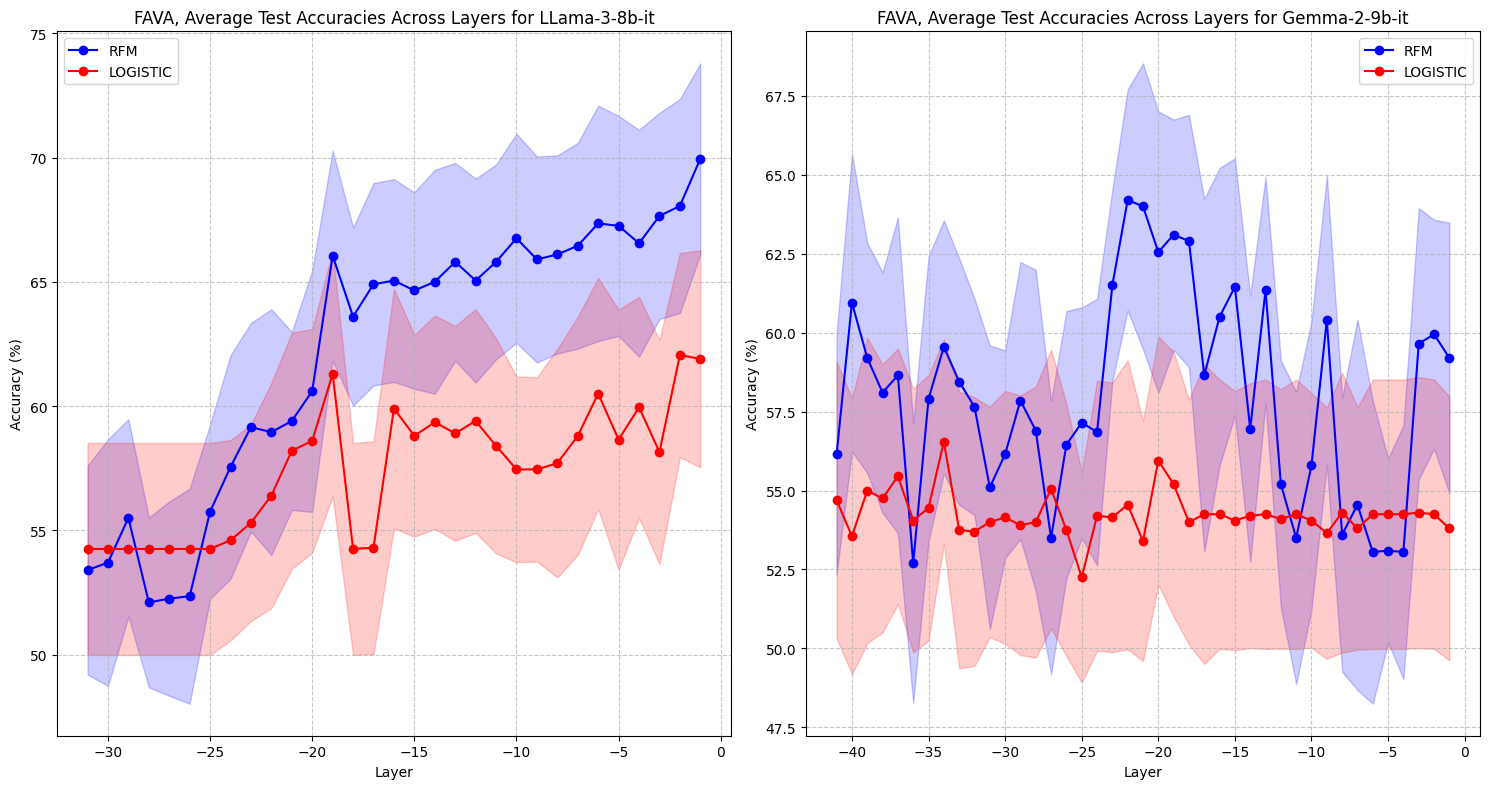

In [2]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os
from collections import defaultdict

# Define the range of seeds
seeds = np.arange(20)
methods = ['rfm', 'logistic']
models = ['llama_3_8b', 'gemma_2_9b']

# Initialize dictionaries to store results
all_results = {}

for model in models:
    all_results[model] = {
        'test': {method: {} for method in methods}
    }

    # Load data for each method
    for method in methods:
        # Process each seed
        for s in seeds:
            # Path for test metrics
            path_test = f'/u/dbeaglehole/mech_interp/neural_controllers/quantitative_comparisons/fava_annotated_results/{model}_it_{method}_seed_{s}_test_metrics.pkl'
            
            # Check if file exists
            if not os.path.exists(path_test):
                print(f"File not found: {path_test}")
                continue
                
            # Load test results
            with open(path_test, 'rb') as f:
                test_results = pickle.load(f)
            
            # Get layer keys (excluding non-dict entries)
            layers_test = [k for k in test_results.keys() if isinstance(test_results[k], dict)]
            
            # Collect per-layer metrics
            for key in layers_test:
                if key not in all_results[model]['test'][method]:
                    all_results[model]['test'][method][key] = []
                all_results[model]['test'][method][key].append(test_results[key]['acc'])

# Calculate average accuracies per layer
avg_results = {}
for model in models:
    avg_results[model] = {}
    for method in methods:
        avg_results[model][method] = {}
        for layer, accs in all_results[model]['test'][method].items():
            if accs:  # Check if we have data for this layer
                avg_results[model][method][layer] = {
                    'mean': np.mean(accs),
                    'std': np.std(accs)
                }


# Plot the results
plt.figure(figsize=(15, 8))

# Define colors and alpha values for shading
colors = {'rfm': 'blue', 'logistic': 'red'}
alpha_fill = 0.2  # Alpha transparency for the shaded region

for i, model in enumerate(models):
    plt.subplot(1, 2, i+1)
    
    for method in methods:
        layer_data = avg_results[model][method]
        print("layer_data.keys()", layer_data.keys())
        if layer_data:
            # Sort layers by their numerical value
            layers = sorted([int(layer) for layer in layer_data.keys() if isinstance(layer, int)])
            print("layers", layers)
            
            # Extract mean and std for plotting
            means = [layer_data[layer]['mean'] for layer in layers if layer in layer_data]
            stds = [layer_data[layer]['std'] for layer in layers if layer in layer_data]
            
            # Plot the mean line
            plt.plot(layers, means, label=method.upper(), marker='o', color=colors[method])
            
            # Add shaded error region
            plt.fill_between(
                layers, 
                [m - s for m, s in zip(means, stds)],  # lower bound
                [m + s for m, s in zip(means, stds)],  # upper bound
                color=colors[method], 
                alpha=alpha_fill
            )
    
    plt.title(f'FAVA, Average Test Accuracies Across Layers for {model.replace(model[0], model[0].upper()).replace("_", "-")}-it')
    plt.xlabel('Layer')
    plt.ylabel('Accuracy (%)')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()

plt.savefig('fava_test_accuracies_across_layers.pdf', format='pdf')
plt.show()